# Linear Regression (Loan Club Dataset)

In the last notebook, we investigated the dataset, and performed basic cleaning on a subset of the data. In this notebook, we see the power of linear regression in modeling the dependancy between different features. For nonlinear relationships, linear regression won't perform well compared to other machine learning models; however, it can give some good insights about the data with its high interpretablity. Typically, linear regression should be your first choice if you are looking for interpertable model.

The following notebook will have two main section:
- **Simple linear regression:** Relation between the outcome and a single predictor.
- **Multiple linear regression:** Relation between the outcome and multiple predictors.  

Furthermore, we shall perform basic tricks to improve the model as follows:
- **Interactions terms:** Introduce interaction terms between the predictors to capture more relations.
- **Nonlinear transformation:** Use log transformation on the features to avoid features skewness.


#### Import neccessary libraries.

In [1]:
#For data manipulation
import pandas as pd
import numpy as np
from patsy import dmatrices
#For data visualization.
import matplotlib.pyplot as plt
import seaborn as sns
#For display options.
from IPython.display import Markdown, display
#For performing linear regression.
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.compat import lzip
# for evaluation of linear regression model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Useful function for Jupyter to display text in bold:
def displaybd(text):
    display(Markdown("**" + text + "**"))

# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10


### Helper Functions:

To make the notebook cleaner, let's define a few helper functions that we will use throughout the notebook.

### Residual Scatter

The plot of $Y$ (actual outcome values) versus $\hat{Y}$ (estimated outcome values) is called the residual scatter. A perfect fit ($R^2 = 1$) corresponds to all points on the 45 degree line, no fit ($R^2 = 0$) corresponds to all points on the vertical line corresonding to the average value
of Y in the sample ($Y$).

In [2]:
# We can do the plot of the original data along with the fitted line:
def residual_scatter(res):
    minval = np.min([np.min(res.fittedvalues), np.min(res.model.endog)])
    maxval = np.max([np.max(res.fittedvalues), np.max(res.model.endog)])
    plt.scatter(x=res.fittedvalues, y=res.model.endog, alpha=0.1)
    # Draw the 45-degree line:
    plt.plot([minval, maxval], [minval, maxval], linestyle="--", color="red", linewidth=3)
    plt.title('The Residual Scatter')
    plt.xlabel('Fitted Values')
    plt.ylabel('Data')
    plt.tight_layout()

### Residual Plot

This plot shows the residuals (difference between actual and estimated values of the outcome) on the vertical axis and the fitted values on the horizontal axis. If the points in a residual plot are randomly dispersed around the horizontal axis (the errors aren't corrolated with data), a linear regression model is appropriate for the data. If there is a pattern in the residuals (the errors are corrolated), a nonlinear model is more appropriate.

In [3]:
def residual_plot(res,data,target):
    #-- RESIDUAL PLOT:
    yhat = res.fittedvalues
    ehat = res.resid
    ehatAbs = np.abs(ehat)
    sns.residplot(yhat, target, data=data, lowess=True,
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 3, 'ls': '--', 'alpha': 1.0})
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    
    # Annotations for the largest residuals:
    yPointsTop3 = ehatAbs.sort_values(ascending=False)[:1]
    for i in yPointsTop3.index:
        plt.annotate(i, xy=(1.01*yhat[i], 1.01*ehat[i]), fontsize=12);

### Leverage Plot

This plot shows if any outliers have influence over the regression fit. These influential outliers are called leverage points ( Observations with high leverage have an unusual value for xi).Anything outside the group and outside “Cook’s Distance” lines, may have an influential effect on model fit.

In [24]:
def leverage_plot(res):
    # leverage:
    xleverage = res.get_influence().hat_matrix_diag
    # Cook's distance:
    modelCooks = res.get_influence().cooks_distance[0]
    # Studentized residuals
    ehatStudentized = res.get_influence().resid_studentized_internal
    
    plt.scatter(xleverage, ehatStudentized, alpha=0.5)
    sns.regplot(xleverage, ehatStudentized, scatter=False, 
                ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.8});
    #ax.set_xlim(np.min(xleverage) - 0.001, 1.05*np.max(xleverage))
    #ax.set_ylim(1.05*np.min(ehatStudentized), 1.1*np.max(ehatStudentized))
    plt.title('Residuals vs Leverage')
    plt.xlabel('Leverage')
    plt.ylabel('Studentized Residuals')
    
    # Annotations for the points with the largest Cook's distance:
    yPointsTop3 = np.flip(np.argsort(modelCooks), 0)[:3]
    print("Top 3 leverage points: ", yPointsTop3)
    for i in yPointsTop3:
        plt.annotate(i, xy=(1.01*xleverage[i], 1.01*ehatStudentized[i]), fontsize=14)

    # Shenanigans for Cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=2, ls=':', color='green')

    pnum = len(res.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.050, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.050, 50)) # 1 line
    plt.legend(loc='upper right', fontsize=14);

### Scale-Location Plot

Scale-Location plot shows whether residuals are spread equally along the ranges of input variables (predictor). The assumption of equal variance (homoskedasticity) could also be checked with this plot. If we see a horizontal line with randomly spread points, it means that the model is good.

In [29]:
def scale_location_plot(res):
    
    yhat = res.fittedvalues
    # Studentized residuals
    ehatStudentized = res.get_influence().resid_studentized_internal
    # Asolute squared studentized residuals
    ehatStudentizedAbsSqrt = np.sqrt(np.abs(ehatStudentized))
    plt.scatter(yhat, ehatStudentizedAbsSqrt, alpha=0.5)
    sns.regplot(yhat, ehatStudentizedAbsSqrt, scatter=False, ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.9})

    plt.title('Scale-Location')
    plt.xlabel('Fitted values')
    plt.ylabel('$\sqrt{|Studentized\; Residuals|}$');

    # Annotations for the largest residuals:
    yPointsTop3 = np.flip(np.argsort(ehatStudentizedAbsSqrt), 0)[:3]
    print(yPointsTop3)
    for i in yPointsTop3:
        plt.annotate(i, xy=(1.01*yhat[i], 1.01*ehatStudentizedAbsSqrt[i]), fontsize=14);

### Full Diagnostic Plots:

These are a full suite of plots to diagnose the linear regression models. This code is a reproduction with the diagnostic plots in R (Based on https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034
). 

In [6]:
def diagnostic_plots(res,target):
    yhat = res.fittedvalues
    ehat = res.resid
    # Studentized residuals
    ehatStudentized = res.get_influence().resid_studentized_internal
    # Asolute squared studentized residuals
    ehatStudentizedAbsSqrt = np.sqrt(np.abs(ehatStudentized))
    # absolute residuals
    ehatAbs = np.abs(ehat)
    # leverage:
    xleverage = res.get_influence().hat_matrix_diag
    # Cook's distance:
    modelCooks = res.get_influence().cooks_distance[0]

    fig = plt.figure(figsize=[13, 11.5])
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    #-- RESIDUAL PLOT:

    ax = fig.add_subplot(2, 2, 1)
    sns.residplot(yhat, target, data=loan_club, lowess=True, ax=ax,
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 3, 'ls': '--', 'alpha': 1.0})
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

    # Annotations for the largest residuals:
    yPointsTop3 = ehatAbs.sort_values(ascending=False)[:3]
    for i in yPointsTop3.index:
        ax.annotate(i, xy=(1.01*yhat[i], 1.01*ehat[i]), fontsize=14);

    #-- QQ PLOT:
    # This one shows how well the distribution of residuals fit the normal distribution.
    # This plots the standardized (z-score) residuals against the theoretical normal quantiles.
    # Anything quite off the diagonal lines may be a concern for further investigation.

    ax = fig.add_subplot(2, 2, 2)
    QQ = ProbPlot(data=ehatStudentized, fit=True)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=2, ls="--", ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Studentized Residuals');

    # Annotations for the largest residuals:
    yPointsTop3 = np.flip(np.argsort(np.abs(ehatStudentized)), 0)[:3]
    for r, i in enumerate(yPointsTop3):
        xy = (1.01 * np.flip(QQ.theoretical_quantiles, 0)[r], 1.01 * ehatStudentized[i])
        ax.annotate(i, xy=xy, fontsize=14);

    #-- SCALE-LOCATION PLOT:

    ax = fig.add_subplot(2, 2, 3)
    plt.scatter(yhat, ehatStudentizedAbsSqrt, alpha=0.5)
    sns.regplot(yhat, ehatStudentizedAbsSqrt, scatter=False, ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.9},
                ax=ax)

    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Studentized\; Residuals|}$');

    # Annotations for the largest residuals:
    yPointsTop3 = np.flip(np.argsort(ehatStudentizedAbsSqrt), 0)[:3]
    for i in yPointsTop3:
        ax.annotate(i, xy=(1.01*yhat[i], 1.01*ehatStudentizedAbsSqrt[i]), fontsize=14);

    #-- LEVERAGE PLOT:
    # This plot shows if any outliers have influence over the regression fit.
    # Anything outside the group and outside “Cook’s Distance” lines, may have
    # an influential effect on model fit.

    ax = fig.add_subplot(2, 2, 4)
    plt.scatter(xleverage, ehatStudentized, alpha=0.5)
    sns.regplot(xleverage, ehatStudentized, scatter=False, 
                ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 3, 'ls':'--', 'alpha': 0.8},
                ax = ax);
    #ax.set_xlim(np.min(xleverage) - 0.001, 1.05*np.max(xleverage))
    #ax.set_ylim(1.05*np.min(ehatStudentized), 2*np.max(ehatStudentized))
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Studentized Residuals')

    # Annotations for the points with the largest Cook's distance:
    yPointsTop3 = np.flip(np.argsort(modelCooks), 0)[:3]
    for i in yPointsTop3:
        ax.annotate(i, xy=(1.01*xleverage[i], 1.01*ehatStudentized[i]), fontsize=14)

    # Shenanigans for Cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=2, ls=':', color='green')

    pnum = len(res.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * pnum * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right', fontsize=14);

### Variance Inflaction Factors (VIF):
Collinearity between two features can be detected with a corrolation matrix. However, collinearity can arise among more than two features (Multicollinearity). Variance Inflaction Factor (VIF) can detect this multicollinearity. A rule of thumb would be to drop features with VIF greater than 5 or 10. VIF is estimated from the regression between a given features and all other features.

In [7]:
def VIF(data,formula):
    # Get Y and X dataframes based on the full regression:
    # NB: We need to explicitly include the constant here:
    Y, X = dmatrices(formula, data=data, return_type='dataframe')
    # Calculate VIFs for all columns:
    vif = pd.DataFrame()
    # We don't calculate VIF for the column with index '0', because this is the Intercept column:
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
    vif["features"] = X.columns[1:]
    print(vif.round(2))

## Get the data

This data was sampled and cleaned from the original loan club dataset (See previous notebook). We select a subset of features that we believe to be of the outmost importance. 

In [8]:
# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)

important_cols = ['loan_amnt','loan_status','term','int_rate','sub_grade','emp_title','emp_length','home_ownership',
                  'annual_inc','verification_status','issue_d','purpose','zip_code','addr_state','total_pymnt',
                  'bc_util','tot_coll_amt','tot_cur_bal','last_pymnt_d','earliest_cr_line','percent_bc_gt_75','revol_bal']
loan_club = loan_club[important_cols]


#### Explore the data

Let's have a look at the data.

In [9]:
pd.set_option('display.max_columns', None) #Show all columns
loan_club.head()

,loan_amnt,loan_status,term,int_rate,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,total_pymnt,bc_util,tot_coll_amt,tot_cur_bal,last_pymnt_d,earliest_cr_line,percent_bc_gt_75,revol_bal
0,12000,Current,60 months,15.05,C4,HUman Resource Manager,2 years,RENT,75000.0,Source Verified,2017-10-01,credit_card,077xx,NJ,4547.720000,54.8,50.0,68729.0,2019-02-01,2011-09-01,40.0,15447
1,7000,Fully Paid,36 months,14.33,C1,Motorwerks BMW,3 years,MORTGAGE,130000.0,Not Verified,2013-01-01,debt_consolidation,554xx,MN,8608.560001,45.4,0.0,229910.0,2015-07-01,2006-04-01,50.0,1361
2,35000,Current,36 months,10.91,B4,System Analyst,3 years,RENT,115000.0,Verified,2017-08-01,moving,180xx,PA,20577.450000,54.8,0.0,51884.0,2019-02-01,2008-12-01,30.0,38248
3,25000,Fully Paid,60 months,11.49,B5,Driver,4 years,MORTGAGE,80000.0,Not Verified,2016-08-01,debt_consolidation,840xx,UT,29096.166627,55.4,0.0,220181.0,2018-03-01,2008-11-01,42.9,19451
4,5000,Fully Paid,36 months,5.32,A1,electrician,10+ years,MORTGAGE,80000.0,Not Verified,2015-07-01,home_improvement,088xx,NJ,5418.499148,32.9,0.0,252273.0,2018-06-01,1993-02-01,0.0,6283


#### Summarize the data

This summary can give us a basic overview of the structure of the data.

In [10]:
pd.set_option('display.max_columns', None) #Show all columns
display(loan_club.describe())
# Including only string columns in the description:
display(loan_club.describe(include=[np.object]))

,loan_amnt,int_rate,annual_inc,total_pymnt,bc_util,tot_coll_amt,tot_cur_bal,percent_bc_gt_75,revol_bal
count,73100.000000,73100.000000,7.310000e+04,73100.000000,73100.000000,73100.000000,7.310000e+04,73100.000000,73100.000000
mean,15382.428865,13.237644,8.131598e+04,12154.732398,57.222640,221.528618,1.523538e+05,41.392259,16544.258741
std,9222.894241,4.893915,6.672570e+04,10000.901857,28.403043,1880.526974,1.617262e+05,35.778155,21146.636903
min,1000.000000,5.310000,2.000000e+01,60.810000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8000.000000,9.710000,5.000000e+04,4514.257500,34.800000,0.000000,3.378975e+04,0.000000,6148.750000
50%,13662.500000,12.730000,6.970000e+04,9457.560000,59.200000,0.000000,9.338100e+04,33.300000,11531.000000
75%,20000.000000,16.020000,9.700000e+04,17062.016465,82.100000,0.000000,2.267828e+05,66.700000,20341.000000
max,40000.000000,30.990000,6.599100e+06,62707.614649,318.200000,296368.000000,3.618166e+06,100.000000,867528.000000


,loan_status,term,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,zip_code,addr_state
count,73100,73100,73100,73100,73100,73100,73100,73100,73100,73100
unique,7,2,35,32708,11,6,3,13,874,50
top,Fully Paid,36 months,C1,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,750xx,CA
freq,33887,51137,4728,1411,26069,37626,30854,41524,845,9850


#### Visualize numerical features.

We can determine if there is any strong corrolations between features (scatter plot) or if there is some clear outliers (density plot).

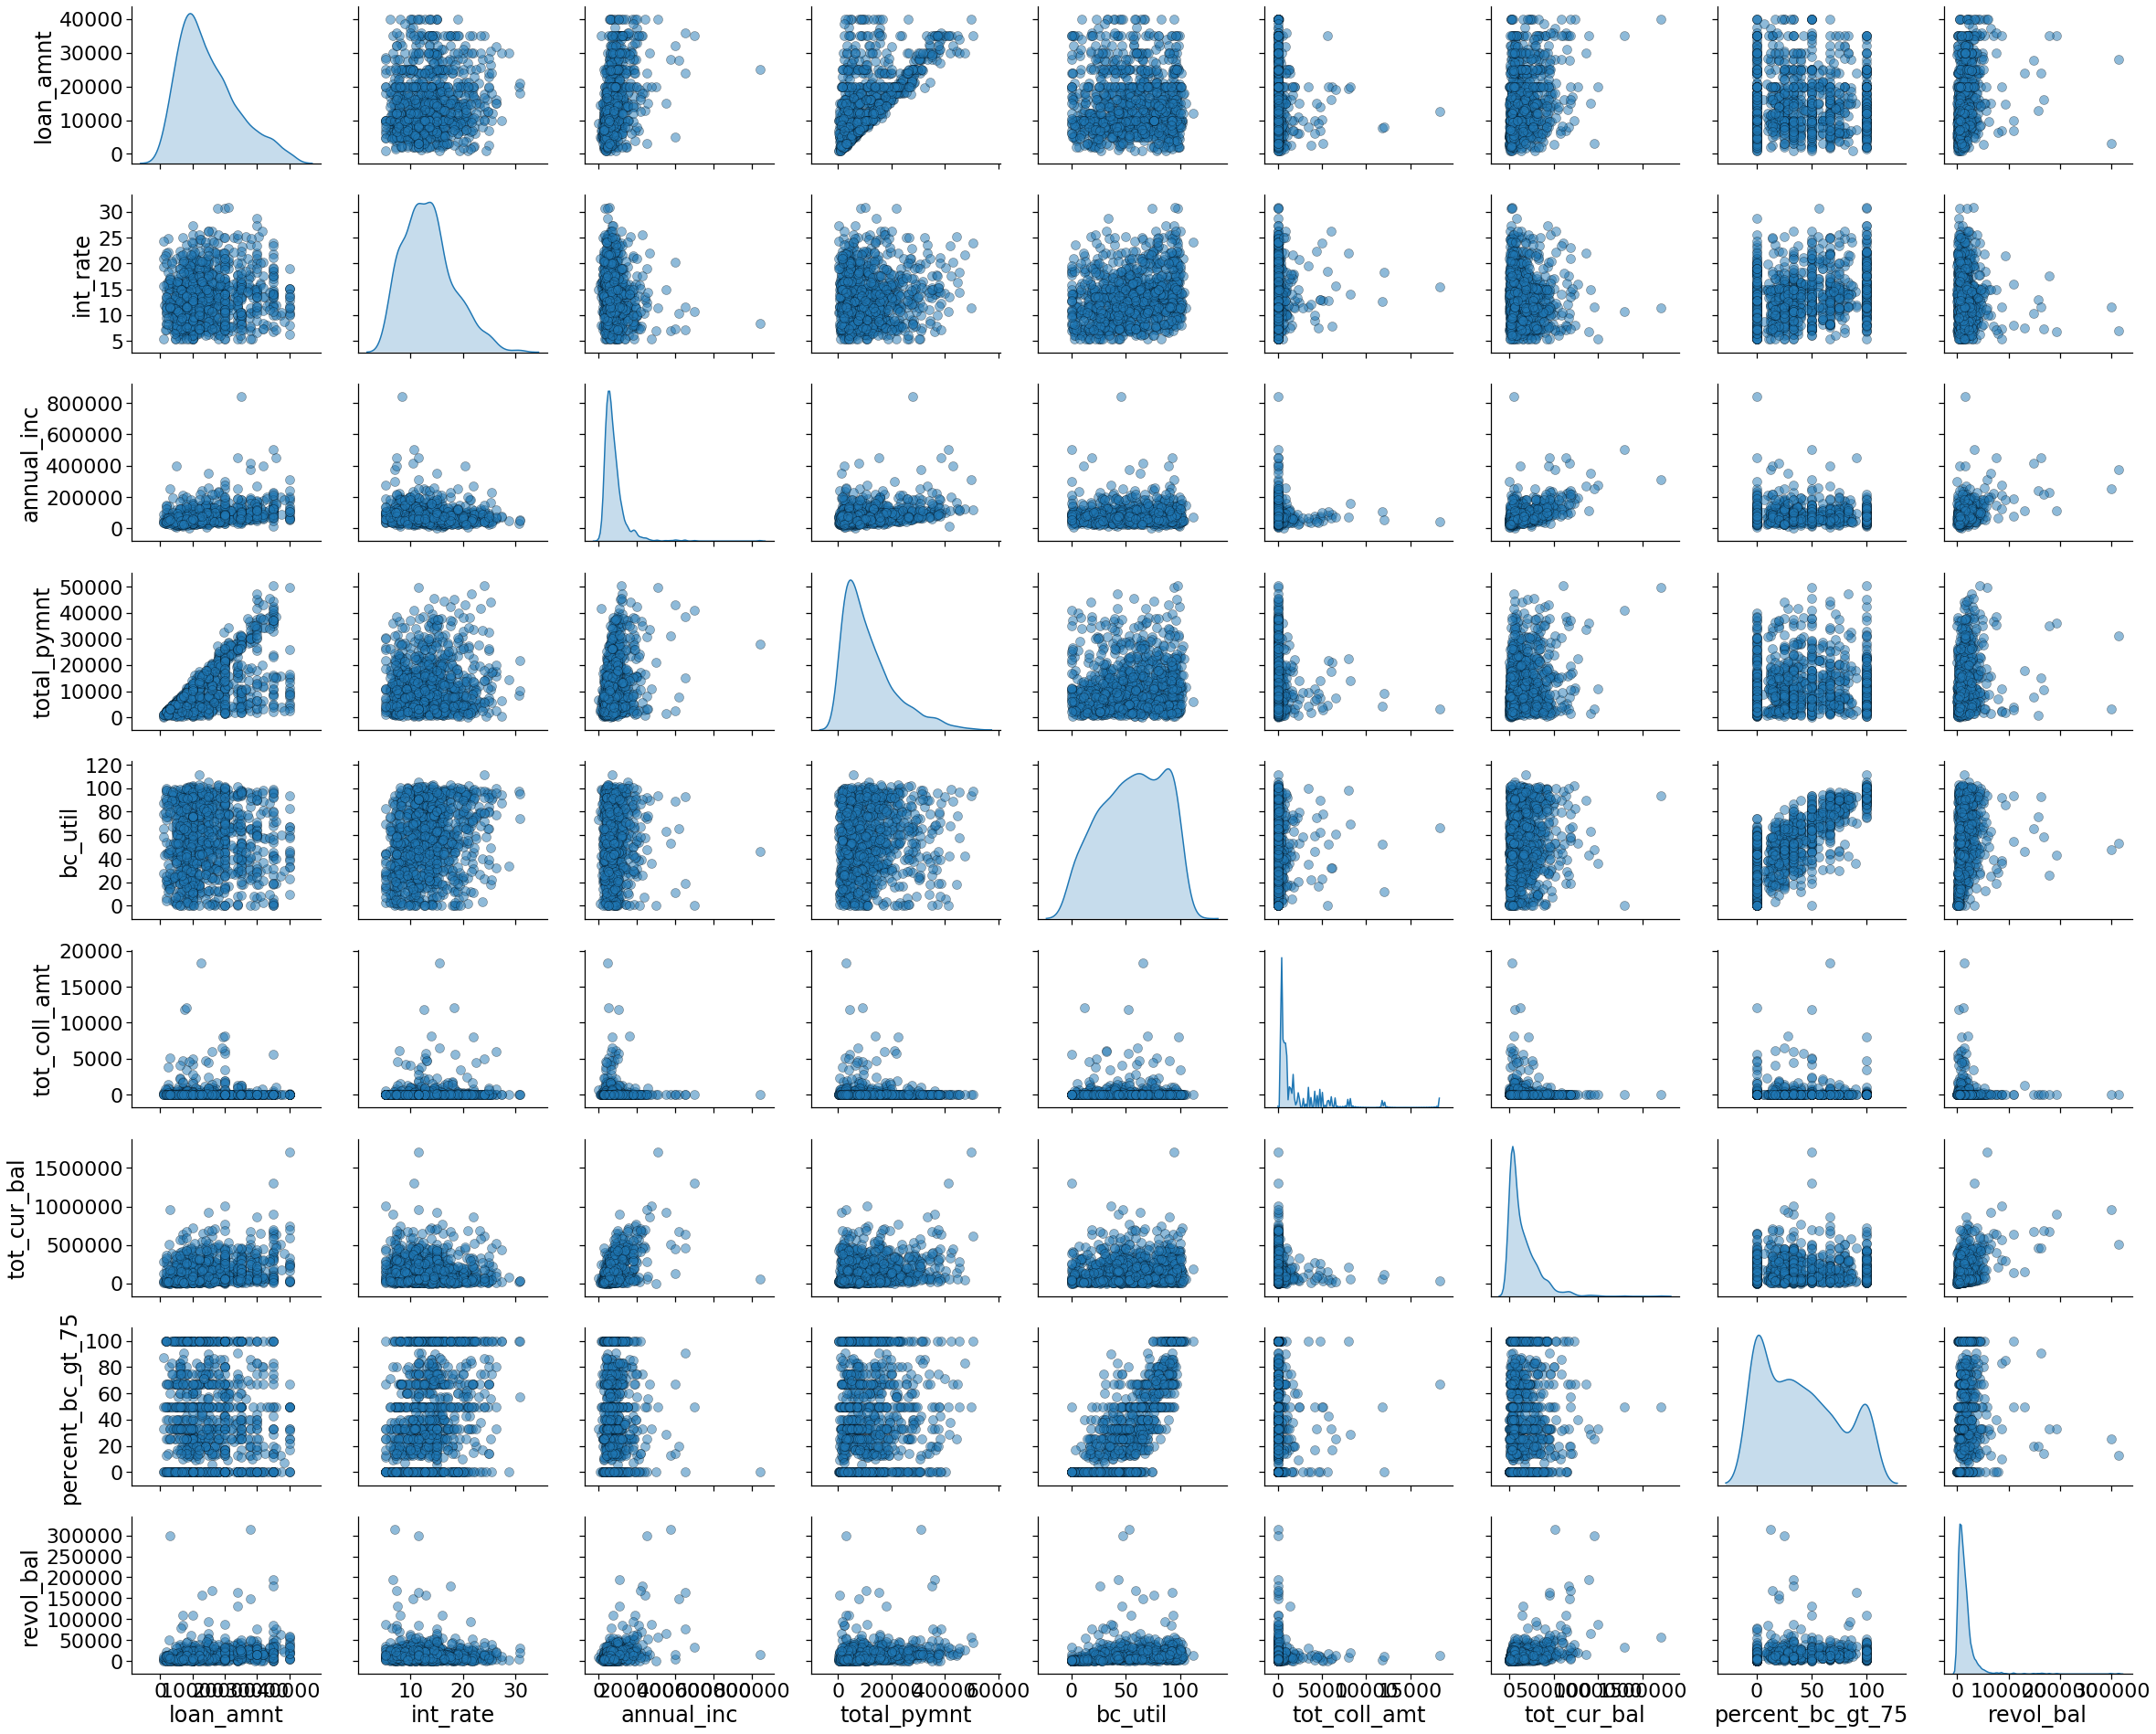

In [11]:
loan_club_vis = loan_club.sample(1000)
cols = list(loan_club.select_dtypes(include=[np.number]).columns)
# Use plotting context to tempoprary change plotting settings
# (the earlier specified font is too large)
pairplot_rc = {"lines.markersize": 10}
with sns.plotting_context("notebook", font_scale=2.0, rc=pairplot_rc):
    pp = sns.pairplot(loan_club_vis[cols],
                      height=3, aspect=1.2,
                      # Change marker styles:
                      plot_kws=dict(edgecolor="k", linewidth=0.5, alpha=0.5),
                      # "diag" adjusts/tunes the diagonal plots:
                      diag_kws=dict(shade=True),
                      diag_kind="kde")
    # Set custom space between graphs:
    pp.fig.subplots_adjust(wspace=0.2, hspace=0.2)

We can detect some outliers from this plot as in the revol_bal or annual_inc. We can detect some corrolation between the total_pynmt and the loan_amnt.  

## Linear Regression

For this model, we choose the **total_pymnt** (Total payment) as our ***outcome*** feature. This feature is the total amount paid back by this loan. For fully-paid loans, this value should depend mainly on the intial **loan_amnt** (loan amount) and the **int_rate** (interest rate). Thus, these features were selected as the ***predictors*** for our model. Additional features such as **term** (categorical feature) and **revol_bal** could be a helpful predictors as well.
We can use the ***statsmodels*** package to create these linear regression models.

First, we need to do some filtering to include only loans that are fully-paid. Other loans will create noise signal and result in reduced perfomance of our model.

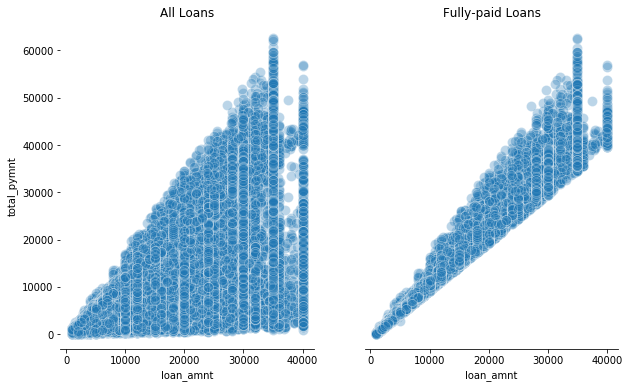

In [12]:
loan_club_fully_paid = loan_club[loan_club['loan_status']=='Fully Paid'].reset_index(drop=True)

f, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.despine(left=True)

sns.scatterplot(x='loan_amnt',y='total_pymnt',data = loan_club,ax=axes[0],alpha=0.3)
axes[0].set(title="All Loans");

sns.scatterplot(x='loan_amnt',y='total_pymnt',data = loan_club_fully_paid,ax=axes[1],alpha=0.3)
axes[1].set(title="Fully-paid Loans");
axes[1].get_yaxis().set_visible(False)


- **It is clear that analysis using only Fully-paid loans would be more intuitive.**

### Simple Linear Regression

Let's build a simple linear regression model to describe the outcome (total payment) using a single predictor (loan amount).

In [13]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 8.841e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        16:53:05   Log-Likelihood:            -3.0608e+05
No. Observations:               33887   AIC:                         6.122e+05
Df Residuals:                   33885   BIC:                         6.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -306.8951     21.285    -14.418      0.000    -348.615    -265.175
loan_amnt      1.1829      0.001    940.251      0.000       1.180       1.185
==============================================================================
Omnibus:                    16894.875   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205363.857
Skew:                           2.108   Prob(JB):                         0.00
Kurtosis:                      14.299   Cond. No.                     3.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Linear regression fit:**

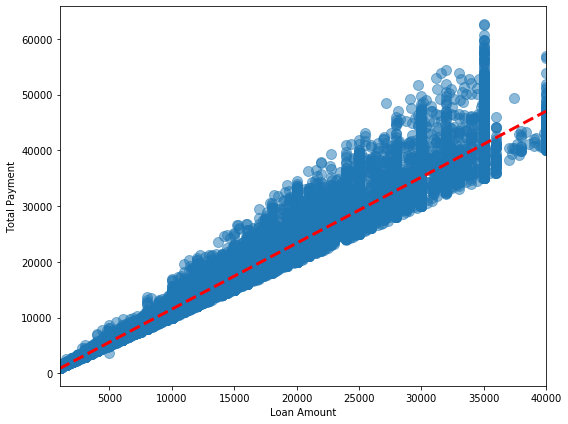

In [14]:
# We can do the plot of the original data along with the fitted line:
displaybd("Linear regression fit:")
fig = sm.graphics.abline_plot(model_results=res, linestyle="--", color="red", linewidth=3)
fig.set_figwidth(8)
fig.set_figheight(6)

plt.scatter(x=loan_club_fully_paid["loan_amnt"], y=loan_club_fully_paid["total_pymnt"], alpha=0.5)
plt.xlabel('Loan Amount')
plt.ylabel('Total Payment')
plt.tight_layout()

#### (a) Model Fit: Residual Scatter

From the model summary, we see that $R^2 = 0.963$. The $R^2$ value can evaluate the fitness of the model, and how much of the variance in the data can be explained by model. The model can explain about 96% of the model variance. This is a relatively good model.  

We can further see the model fitness through a residual scatter.

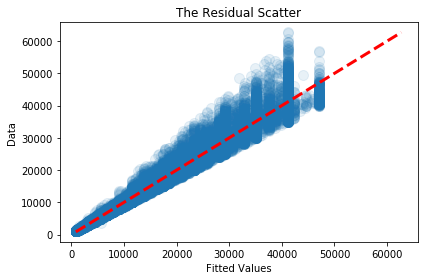

In [15]:
residual_scatter(res)

**The residual scatter shows that our model is almost around the $45^o$ line. We can see some increasing variations. We will tackle this later.**

#### (b) Model coefficients:

For a simple linear regression model, we have two coefficients; an intercept $c_0$ and a slope $c_1$ **($y = c_0 + c_1*x_1$)**. We use the "params" attribute to return the coefficients of the model.

In [16]:
# We can look at the estimated coefficients:
displaybd("Estimated coefficients:")
print(np.round(res.params,2))

**Estimated coefficients:**

Intercept   -306.90
loan_amnt      1.18
dtype: float64


The coefficients can be interpreted as follows: 
- Intercept  $c_0 = -306.9$ : This is the total amount returned in case of loan amount of 0. This intercept should be almost zero, but we get a non-zero value to minimize the residual errors. 
- loan_amnt  $c_1 = 1.18$ : This is coefficient of loan amount. This means that for every dollar increase in the loan amount the total payment would increase with 1.18 dollars on average. This coefficient could be considered as the mean interest rate.   

#### (c) Heteroskedasticity:

To evaluate the hetroskedasticity, we can first use a residual plot.

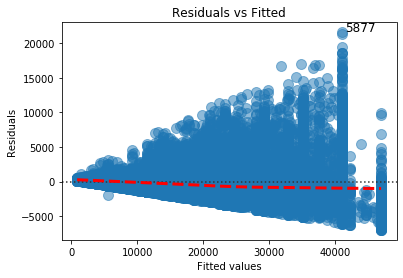

In [17]:
residual_plot(res,loan_club_fully_paid,'total_pymnt')

**The residual plot shows a clear hetroskedasticity. The variance in the residuals increases with the increase of the fitted values.**

In [18]:
#----
displaybd("Breusch-Pagan Test for Heteroskedasticity:")

# COMMENT: The resutl of the Breusch-Pagan test for heteroskedasticity is either the
# Lagrange multiplier statistics or the F-statistics. Both are valid statistics.
# We need to look at the p-values associated with them. If p-values are small, then
# we reject the null hypothesis of homoskedasticity.
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
bp_test = het_breuschpagan(res.resid, res.model.exog)
print(lzip(name, bp_test))

#----
displaybd("White Test for Heteroskedasticity:")

# COMMENT: The same comments as above for the Breusch-Pagan test apply for the White
# test as well. In addition to that, note that the White test requires wquares and
# interaction terms of the exogenous variables. However, when running het_white(...),
# we only need to supply the exogenous variables. Squares and interaction terms are
# automatically included in the auxiliary regression.
white_test = het_white(res.resid, res.model.exog)
print(lzip(name, white_test))

**Breusch-Pagan Test for Heteroskedasticity:**

[('Lagrange multiplier statistic', 4255.953326893293), ('p-value', 0.0), ('f-value', 4866.955260566875), ('f p-value', 0.0)]


**White Test for Heteroskedasticity:**

[('Lagrange multiplier statistic', 4797.367054813905), ('p-value', 0.0), ('f-value', 2794.019188753887), ('f p-value', 0.0)]


**From these two tests, we can see that the p-value for the Lagrange multiplier statistic and the F-value is zero. This would clearly prove the hetroskedasticity.**

#### (d): heteroskedasticity-robust standard errors 

To incorporate the effect of hetroskedasticity, we can fit our linear regression under the assumption of heteroskedasticity-robust standard error. 

In [19]:
# PART 2.2: Regression of total_pymnt on loan_amnt with
# heteroskedasticity-robust standard errors

model = sm.OLS.from_formula('total_pymnt~loan_amnt', data=loan_club_fully_paid)
# Using the option cov_type='HC0' will use White’s
# heteroskedasticity-robust standard errors:
res = model.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 3.482e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        16:53:20   Log-Likelihood:            -3.0608e+05
No. Observations:               33887   AIC:                         6.122e+05
Df Residuals:                   33885   BIC:                         6.122e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -306.8951     21.118    -14.533      0.000    -348.285    -265.505
loan_amnt      1.1829      0.002    590.053      0.000       1.179       1.187
==============================================================================
Omnibus:                    16894.875   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205363.857
Skew:                           2.108   Prob(JB):                         0.00
Kurtosis:                      14.299   Cond. No.                     3.27e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Due to the large sample size, we can't see any differences in the fitted model under the heteroscedasticity robust assumption.** 

We can futher compare the errors of the standard model and the heteroscedastic model.

In [20]:
res_standrad = model.fit()
res_hetroskedasticity = model.fit(cov_type='HC0')
displaybd("Standard Errors Vs. Heteroskedasticity errors:")
print("Standrad Errors: ",np.round(np.sqrt(res_standrad.scale),2))
print("Heteroskedasticity Robust Standard Errors: ",np.round(np.sqrt(res_hetroskedasticity.scale),2))


**Standard Errors Vs. Heteroskedasticity errors:**

Standrad Errors:  2025.35
Heteroskedasticity Robust Standard Errors:  2025.35


**Again,even with the heteroscedasticity in the data, there is no clear change in the residual errors due to the large sample size. Thus, we can use any of the model interchangeably.**  

#### (e) Heteroskedasticity Coefficients:

In [21]:
displaybd("95% Confidence Intervals of the estimated coefficients:")
print(res_hetroskedasticity.conf_int(alpha=0.05, cols=None))

**95% Confidence Intervals of the estimated coefficients:**

                    0           1
Intercept -348.285336 -265.504942
loan_amnt    1.178948    1.186806


**These confidence intervals are far from zero, which suggests we reject the null hypothesis for both coefficients. The confidence interval is much wider for the intercept compared to the loan amount. This can be noted from the large standard error shown in the data summary.**

In [22]:
print(res_hetroskedasticity.t_test(np.eye(2)))

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0          -306.8951     21.118    -14.533      0.000    -348.285    -265.505
c1             1.1829      0.002    590.053      0.000       1.179       1.187


#### (f) Leverage Points:

Leverage points can damage the goodness of fit of our model, since they fall far from other typical cluster of features. The leverage plot could help determine any leverage points.

Top 3 leverage points:  [ 5877 12141  9566]


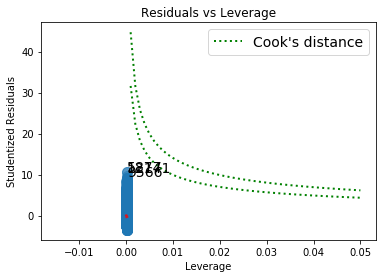

In [25]:
leverage_plot(res)

In [26]:
loan_club_fully_paid['loan_amnt'].iloc[[5877,12141,9566]]

5877     35000
12141    35000
9566     35000
Name: loan_amnt, dtype: int64

**There is no clear leverage points since all of the points are relatively far from the cook's distance line.**

#### (g) Outliers:

Even through outliers wouldn't affect our regression line as severly as leverage points would, exploring these points is important as they might indicate some problems with the data or some meaningful insights.

For two variables it is easy, let's just plot the corresponding violen (or boxplots) plots.

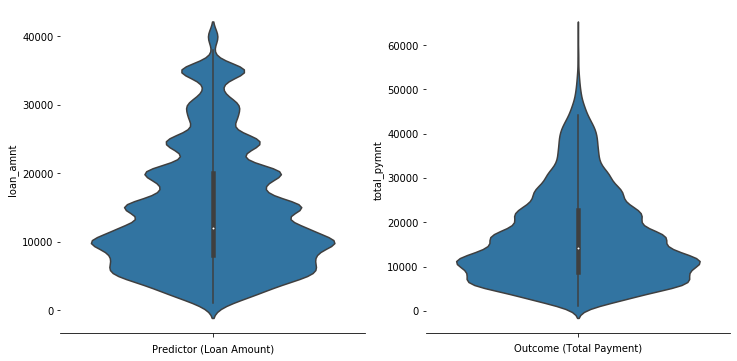

In [27]:
f, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.despine(left=True)

sns.violinplot(loan_club_fully_paid['loan_amnt'],orient='v',ax=axes[0])
axes[0].set(xlabel="Predictor (Loan Amount)");

sns.violinplot(loan_club_fully_paid['total_pymnt'],orient='v',ax=axes[1])
axes[1].set(xlabel="Outcome (Total Payment)");

**We can see some clear outliers the total payment, and the loan amount. These might reduce the quality of our model due to the skewness of the data. One solution to reduce this skewness would be to introduce some nonlinear transformation (log transformation) as will be shown later.**

For more than two features, visualization of outliers might be a bit challenging. A scale-location plot could help us spot the outliers in this case.

[ 5877 12141  9566]


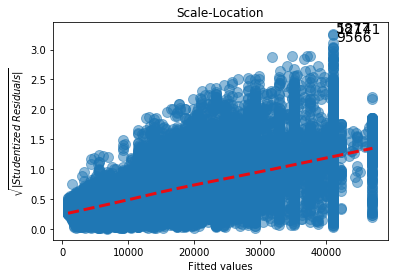

In [30]:
scale_location_plot(res)

In [31]:
loan_club_fully_paid['loan_amnt'].iloc[[ 5877, 12141, 9566]]

5877     35000
12141    35000
9566     35000
Name: loan_amnt, dtype: int64

**The outliers aren't that severe. We can also notice that the outliers match the observations of points with highest leverage.**

#### (h) VIF:

Detecting multicollinearity (corrolation between more than two features) isn't possible using only corrolation coefficients. Variance Inflation Factor (VIF) can help detect any collinearity. For a simple linear regression, VIF doesn't make any sense. However, for multiple linear regression, VIF can help us select important features or perform feature engineering on collinear features. Features with VIF greater than 5, or 10 are considered multicollinear.

In [32]:
VIF(loan_club_fully_paid,'total_pymnt ~ loan_amnt')

   VIF Factor   features
0         1.0  loan_amnt


#### (i) Prediction: 

Finally, we need to use our model to make predictions (regression) on unknown observations. The get_prediction method can be used for this purpose.

In [33]:
# We can predict out-of-sample total_amount with its 95% confidence and prediction intervals:
# Confidence intervals are mean_ci_lower and mean_ci_upper
# Prediction intevals are obs_ci_lower and obs_ci_upper
prediction = res.get_prediction(exog=dict(loan_amnt=[1e3, 1e4, 5e4, 1e5]))
displaybd("Predicted values with their confidence and prediction intervals:")
display(prediction.summary_frame(alpha=0.5))

**Predicted values with their confidence and prediction intervals:**

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,875.981623,19.218231,863.019123,888.944123,-490.156373,2242.119618
1,11521.872476,6.436646,11517.531024,11526.213928,10155.789080,12887.955872
2,58836.942936,80.379857,58782.727546,58891.158325,57469.791041,60204.094831
3,117980.781011,180.471418,117859.054889,118102.507132,116609.291949,119352.270072


- Due to the negative intercept, the expected total payment for a loan amount of 1000 is less than the original loan amount. So the model isn't reliable for low loan amounts.
- Also, due to hetroskedasticity of the data, we can see that the prediction interval is much wider than the confidence intervals.
- The mean standard error of total payment increases with increased loan amount. 

**=======================================================================================================================**
### Multiple Linear Regression

To improve the fitness of our regression model, more features should be added to explain the model variance. We can expect that, in addition to the loan_amnt, the total_pymnt would depend on the loan interest rate (**int_rate**) and the loan **term**.

Let's visualize these dependancies.

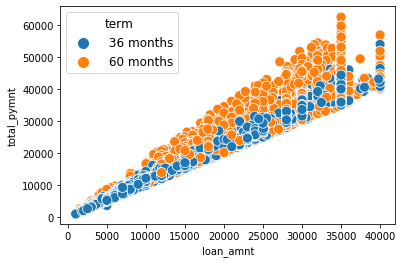

In [34]:
sns.scatterplot(x='loan_amnt',y='total_pymnt',hue="term",data=loan_club_fully_paid)

**For the same loan amount, loans with 60 months term would have a higher total payment than loans with 36 months.**

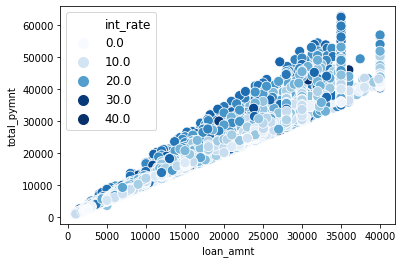

In [35]:
sns.scatterplot(x='loan_amnt',y='total_pymnt',hue="int_rate",palette= "Blues",data=loan_club_fully_paid)

**We can notice the intuitive result of increasing total payment with increasing interest rate.**

Let's build a multiple linear regression model to describe the outcome (total payment) using a multiple predictors (loan amount, interest rate, and term).

In [36]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt+int_rate+term', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 3.775e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:00:26   Log-Likelihood:            -3.0202e+05
No. Observations:               33887   AIC:                         6.041e+05
Df Residuals:                   33883   BIC:                         6.041e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2083.7832     33.766    -61.712      0.000   -2149.966   -2017.600
term[T. 60 months]  1058.7945     27.905     37.943      0.000    1004.100    1113.488
loan_amnt              1.1552      0.001    960.481      0.000       1.153       1.158
int_rate             152.2708      2.309     65.955      0.000     147.746     156.796
==============================================================================
Omnibus:                    11553.166   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163948.847
Skew:                           1.246   Prob(JB):                         0.00
Kurtosis:                      13.484   Cond. No.                     6.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**This multiple regression model had a slightly improved fitness than simple linear regression model.**

Let's do further analysis.

#### (a) Model Fit: Residual Scatter

With more features, we see that $R^2$ has increased ($R^2 = 0.971$). This means that we can explain more of the model variance. 

We can further see the model fitness through a residual scatter.

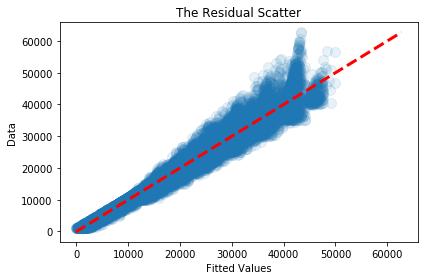

In [37]:
residual_scatter(res)

**We can't see much variation in this plot due to the relatively small improvment between simple and multiple models. The residual scatter shows that our model is almost around the $45^o$ line.**

#### (b) Model coefficients:

For a simple linear regression model, we have two coefficients; an intercept $c_0$ and a slope $c_1$ **($y = c_0 + c_1*x_1 + c_2*x_2 + c_3*x_3$)**. We use the "params" attribute to return the coefficients of the model.

In [38]:
# We can look at the estimated coefficients:
displaybd("Estimated coefficients:")
print(np.round(res.params,2))

**Estimated coefficients:**

Intercept            -2083.78
term[T. 60 months]    1058.79
loan_amnt                1.16
int_rate               152.27
dtype: float64


The coefficients can be interpreted as follows: 
- **Intercept**  $c_0 = -2083.78$ : This is the total amount returned in case of loan amount of 0. This intercept should be almost zero, but we get a non-zero value to minimize the residual errors. The absolute intercept is higher than that for a simple linear regression model. 
- **term (T. 60 months)** $c_1 = 1058.79$ : Since the term feature is a binary categorical variable, the $x_1$ can take values 0 or 1. The coefficients $c_1$ in this case can be interpreted as the mean increase in total loan payment if the loan term changed from 36 months to 60 months. For this model, the term 60 months term loans would return an additional 1058 dollars on average compared to 36 months term loans.   
- **loan_amnt**  $c_2 = 1.16$: This is coefficient of loan amount. This means that for every dollar increase in the loan amount the total payment would increase with 1.16 dollars on average. This coefficient could be considered as the mean interest rate.    
- **int_rate**  $c_3 = 152.27$ : This is coefficient of interest rate. It is interpreted as the mean increase in the total payment for every percent increase in interest rate. In our case, a percent increase in int_rate would increase the returned total_pymnt by 152.27 dollars on average.

However, this might not be the actual effect of increasing interest rate, since there is an interaction between the loan amount and interest rate. We can use this to improve our model in later sections.

#### (c) Heteroskedasticity:

To evaluate the hetroskedasticity, we can first use a residual plot.

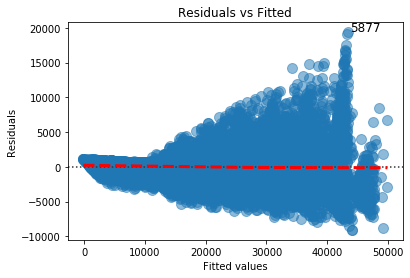

In [39]:
residual_plot(res,loan_club_fully_paid,'total_pymnt')

**The residual plot shows a clear hetroskedasticity. The variance in the residuals increases with the increase of the fitted values.**

**Compared to simple linear regression model, the residuals were slightly reduced.** 

In [40]:
#----
displaybd("Breusch-Pagan Test for Heteroskedasticity:")

name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
bp_test = het_breuschpagan(res.resid, res.model.exog)
print(lzip(name, bp_test))

#----
displaybd("White Test for Heteroskedasticity:")

white_test = het_white(res.resid, res.model.exog)
print(lzip(name, white_test))

**Breusch-Pagan Test for Heteroskedasticity:**

[('Lagrange multiplier statistic', 7963.192249378028), ('p-value', 0.0), ('f-value', 3469.3571456428535), ('f p-value', 0.0)]


**White Test for Heteroskedasticity:**

[('Lagrange multiplier statistic', 11996.338218785715), ('p-value', 0.0), ('f-value', 2320.692438617762), ('f p-value', 0.0)]


**From these two tests, we can see that the p-value for the Lagrange multiplier statistic and the F-value is zero. This would clearly prove the hetroskedasticity.**

#### (d): heteroskedasticity-robust standard errors 

To incorporate the effect of hetroskedasticity, we can fit our linear regression under the assumption of heteroskedasticity-robust standard error. 

In [41]:
# PART 2.2: Regression of total_pymnt on loan_amnt, int_rate, and term with
# heteroskedasticity-robust standard errors

# Using the option cov_type='HC0' will use White’s
# heteroskedasticity-robust standard errors:
res = model.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.838e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:02:39   Log-Likelihood:            -3.0202e+05
No. Observations:               33887   AIC:                         6.041e+05
Df Residuals:                   33883   BIC:                         6.041e+05
Df Model:                           3                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2083.7832     47.613    -43.765      0.000   -2177.103   -1990.463
term[T. 60 months]  1058.7945     35.540     29.791      0.000     989.137    1128.452
loan_amnt              1.1552      0.002    693.736      0.000       1.152       1.158
int_rate             152.2708      3.149     48.351      0.000     146.098     158.443
==============================================================================
Omnibus:                    11553.166   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163948.847
Skew:                           1.246   Prob(JB):                         0.00
Kurtosis:                      13.484   Cond. No.                     6.35e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 6.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Due to the large sample size, we can't see any differences in the fitted model under the heteroscedasticity robust assumption.** 

We can futher compare the errors of the standard model and the heteroscedastic model.

In [42]:
res_standrad = model.fit()
res_hetroskedasticity = model.fit(cov_type='HC0')
displaybd("Standard Errors Vs. Heteroskedasticity errors:")
print("Standrad Errors: ",np.round(np.sqrt(res_standrad.scale),2))
print("Heteroskedasticity Robust Standard Errors: ",np.round(np.sqrt(res_hetroskedasticity.scale),2))


**Standard Errors Vs. Heteroskedasticity errors:**

Standrad Errors:  1796.82
Heteroskedasticity Robust Standard Errors:  1796.82


**Again,even with the heteroscedasticity in the data, there is no clear change in the residual errors due to the large sample size. Thus, we can use any of the model interchangeably.**  

#### (e) Heteroskedasticity Coefficients:

In [43]:
displaybd("95% Confidence Intervals of the estimated coefficients:")
print(res_hetroskedasticity.conf_int(alpha=0.05, cols=None))

**95% Confidence Intervals of the estimated coefficients:**

                              0            1
Intercept          -2177.103245 -1990.463083
term[T. 60 months]   989.136548  1128.452411
loan_amnt              1.151947     1.158475
int_rate             146.098291   158.443354


**These confidence intervals are far from zero, which suggests we reject the null hypothesis for both coefficients.**

In [44]:
print(res_hetroskedasticity.t_test(np.eye(4)))


                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0         -2083.7832     47.613    -43.765      0.000   -2177.103   -1990.463
c1          1058.7945     35.540     29.791      0.000     989.137    1128.452
c2             1.1552      0.002    693.736      0.000       1.152       1.158
c3           152.2708      3.149     48.351      0.000     146.098     158.443


#### (f) Leverage Points:

Leverage points can damage the goodness of fit of our model, since they fall far from other typical cluster of features. The leverage plot could help determine any leverage points.

Top 3 leverage points:  [ 5877 12141  9566]


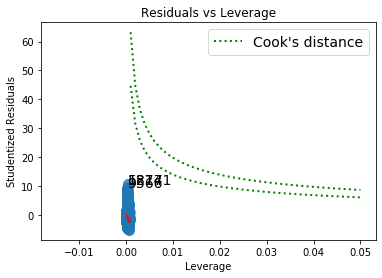

In [45]:
leverage_plot(res)

In [46]:
loan_club_fully_paid['loan_amnt'].iloc[[5877,12141,9566]]

5877     35000
12141    35000
9566     35000
Name: loan_amnt, dtype: int64

**There is no clear leverage points since all of the points are relatively far from the cook's distance line.**

#### (g) Outliers:

Even through outliers wouldn't affect our regression line as severly as leverage points would, exploring these points is important as they might indicate some problems with the data or some meaningful insights.

For more than two features, visualization of outliers might be a bit challenging. A scale-location plot could help us spot the outliers in this case.

[ 5877 12141  9566]


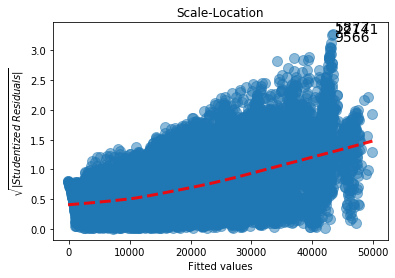

In [47]:
scale_location_plot(res)

In [48]:
loan_club_fully_paid['loan_amnt'].iloc[[ 5877, 12141, 9566]]

5877     35000
12141    35000
9566     35000
Name: loan_amnt, dtype: int64

**The outliers aren't that severe. We can also notice that the outliers match the observations of points with highest leverage.**

#### (h) VIF:

Variance Inflation Factor (VIF) can help detect any collinearity. Features with VIF greater than 5, or 10 are considered multicollinear.

In [49]:
VIF(loan_club_fully_paid,'total_pymnt~loan_amnt+int_rate+term')

   VIF Factor            features
0        1.37  term[T. 60 months]
1        1.16           loan_amnt
2        1.20            int_rate


**All VIF factors are relatively small, so all features are relevant.**

#### (i) Prediction: 

Finally, we need to use our model to make predictions (regression) on unknown observations. The get_prediction method can be used for this purpose.

In [50]:
# We can predict out-of-sample total_amount with its 95% confidence and prediction intervals:
# Confidence intervals are mean_ci_lower and mean_ci_upper
# Prediction intevals are obs_ci_lower and obs_ci_upper
prediction = res.get_prediction(exog=dict(loan_amnt=[1e3, 1e4, 5e4],
                                         int_rate=[5, 10, 20],
                                         term=[' 36 months', ' 36 months', ' 60 months']))
displaybd("Predicted values with their confidence and prediction intervals:")
display(prediction.summary_frame(alpha=0.5))

**Predicted values with their confidence and prediction intervals:**

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-167.218239,32.224154,-188.953100,-145.483378,-1379.347952,1044.911474
1,10991.033181,8.305395,10985.431277,10996.635085,9779.085403,12202.980959
2,59780.968364,81.768527,59725.816331,59836.120397,58567.779268,60994.157460


## Improving our model:

We can attempt to improve the quality of our model through the following approaches:

### Multiple Linear Regression with Interaction Terms:

Some features can have some interactions among each other like loan_amnt and int_rate. Including interaction terms can then improve the model fitness. In this case, our model would still be linear of the form ($y = c_0*x_0 + c_1*x_1 + c$<sub>01</sub> $*x_0*x_1$) in case of only two terms.

In [51]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt*int_rate*term', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.748e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:33   Log-Likelihood:            -3.0074e+05
No. Observations:               33887   AIC:                         6.015e+05
Df Residuals:                   33879   BIC:                         6.016e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               -65.4005     61.168     -1.069      0.285    -185.293      54.492
term[T. 60 months]                      850.0989    217.158      3.915      0.000     424.461    1275.737
loan_amnt                                 1.0244      0.004    263.354      0.000       1.017       1.032
loan_amnt:term[T. 60 months]              0.0042      0.010      0.418      0.676      -0.016       0.024
int_rate                                  6.9639      4.700      1.482      0.138      -2.249      16.176
int_rate:term[T. 60 months]             -51.5912     13.001     -3.968      0.000     -77.075     -26.108
loan_amnt:int_rate                        0.0092      0.000     30.605      0.000       0.009       0.010
loan_amnt:int_rate:term[T. 60 months]     0.0026      0.001      4.258      0.000       0.001       0.004
==============================================================================
Omnibus:                     6419.068   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121496.242
Skew:                           0.387   Prob(JB):                         0.00
Kurtosis:                      12.244   Cond. No.                     6.57e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**We can notice an improvment in the $R^2$ value. However, some of the coefficients has a high p-value meaning we fail to reject the null hypothesis. In this case, we should remove these features. In our case, we can remove interation with the term feature as it's contibution can probably be zero.**

**Interpreting the coefficients with interaction terms isn't as intuitive as without them. Even though the model can have better fitness, it become less interpretable.**

In [52]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt*int_rate + term', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.039e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:33   Log-Likelihood:            -3.0086e+05
No. Observations:               33887   AIC:                         6.017e+05
Df Residuals:                   33882   BIC:                         6.018e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            150.8378     55.965      2.695      0.007      41.144     260.532
term[T. 60 months]   860.9453     27.260     31.583      0.000     807.515     914.375
loan_amnt              1.0096      0.003    317.273      0.000       1.003       1.016
int_rate             -18.4871      4.129     -4.477      0.000     -26.580     -10.394
loan_amnt:int_rate     0.0111      0.000     49.142      0.000       0.011       0.012
==============================================================================
Omnibus:                     7169.103   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131241.667
Skew:                           0.534   Prob(JB):                         0.00
Kurtosis:                      12.582   Cond. No.                     1.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**We didn't loss our goodness of fit, but eliminated uncessary features.
We can also notice that the intercept is becoming more sensible.**

### Multiple Linear Regression with More Features:

Let's introduce more features and see if the fitness improve.

In [53]:
allColumns = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
allColumns.remove("total_pymnt")
allColumns = "+".join(allColumns)
model = sm.OLS.from_formula('total_pymnt~' + allColumns + '+term', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.288e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:33   Log-Likelihood:            -3.0163e+05
No. Observations:               33887   AIC:                         6.033e+05
Df Residuals:                   33877   BIC:                         6.034e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2234.5033     38.731    -57.692      0.000   -2310.418   -2158.589
term[T. 60 months]  1138.4055     27.804     40.943      0.000    1083.908    1192.903
loan_amnt              1.1580      0.001    882.756      0.000       1.155       1.161
int_rate             130.1237      2.423     53.709      0.000     125.375     134.872
annual_inc            -0.0004      0.000     -2.510      0.012      -0.001   -9.35e-05
bc_util                6.2577      0.645      9.702      0.000       4.993       7.522
tot_coll_amt           0.0009      0.004      0.215      0.830      -0.008       0.009
tot_cur_bal           -0.0006   7.11e-05     -8.352      0.000      -0.001      -0.000
percent_bc_gt_75       2.8780      0.508      5.664      0.000       1.882       3.874
revol_bal              0.0007      0.001      1.401      0.161      -0.000       0.002
==============================================================================
Omnibus:                    12023.610   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171071.866
Skew:                           1.312   Prob(JB):                         0.00
Kurtosis:                      13.690   Cond. No.                     9.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**There is no clear improvement in fitness; on the contrary, it had slightly dropped. There is a few features with p-values greater than 0.005 (a hard threshold for selecting features).**

Let's remove these features, and see if there is any improvement.

In [54]:
allColumns = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
allColumns = set(allColumns) - set(['total_pymnt','tot_coll_amt','revol_bal','annual_inc'])
allColumns = "+".join(allColumns)
model = sm.OLS.from_formula('total_pymnt~' + allColumns + '+term', data=loan_club_fully_paid)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.932e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:33   Log-Likelihood:            -3.0164e+05
No. Observations:               33887   AIC:                         6.033e+05
Df Residuals:                   33880   BIC:                         6.033e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2255.2255     37.916    -59.480      0.000   -2329.542   -2180.909
term[T. 60 months]  1140.6798     27.763     41.086      0.000    1086.263    1195.097
int_rate             130.3049      2.417     53.915      0.000     125.568     135.042
tot_cur_bal           -0.0006   6.35e-05     -9.783      0.000      -0.001      -0.000
percent_bc_gt_75       2.8930      0.508      5.695      0.000       1.897       3.889
loan_amnt              1.1576      0.001    928.815      0.000       1.155       1.160
bc_util                6.3432      0.642      9.878      0.000       5.085       7.602
==============================================================================
Omnibus:                    12006.842   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           170459.475
Skew:                           1.310   Prob(JB):                         0.00
Kurtosis:                      13.670   Cond. No.                     9.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Remove outliers

If we remove the outliers, we expect a slight improvement of the model.

In [55]:
delete_entries = []
cols = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
for col in cols:
    col_data = loan_club_fully_paid[col]
    delete_entries.extend(col_data[col_data >= col_data.quantile(0.95)].index.tolist())
print("Number of outliers: ", len(delete_entries))
loan_club_fully_paid_no_outliers = loan_club_fully_paid.drop(set(delete_entries),axis = 0)

Number of outliers:  19198


In [56]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt+int_rate + term', data=loan_club_fully_paid_no_outliers)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 3.242e+05
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:34   Log-Likelihood:            -1.8405e+05
No. Observations:               21618   AIC:                         3.681e+05
Df Residuals:                   21614   BIC:                         3.681e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1668.7213     32.273    -51.706      0.000   -1731.979   -1605.464
term[T. 60 months]   813.1186     24.605     33.047      0.000     764.891     861.347
loan_amnt              1.1383      0.001    903.396      0.000       1.136       1.141
int_rate             136.1053      2.313     58.837      0.000     131.571     140.639
==============================================================================
Omnibus:                     3714.695   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31029.872
Skew:                           0.589   Prob(JB):                         0.00
Kurtosis:                       8.750   Cond. No.                     6.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Indeed, the model has improved with removing the outliers. However, these outliers weren't a result of data collection problems; thus, removing them would damage our model.**

## Log-Linear Regression

Nonlinear transformation of the features can be effective especially in case of feature skewness. Let's try log transformation.

In [57]:
loan_club_fully_paid_log = loan_club_fully_paid.copy()
loan_club_fully_paid_log['loan_amnt'] = np.log(loan_club_fully_paid['loan_amnt'])
loan_club_fully_paid_log['int_rate'] = np.log(loan_club_fully_paid['int_rate'])
loan_club_fully_paid_log['total_pymnt'] = np.log(loan_club_fully_paid['total_pymnt'])

In [58]:
model = sm.OLS.from_formula('total_pymnt~loan_amnt+int_rate+term', data=loan_club_fully_paid_log)
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.072e+06
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:06:34   Log-Likelihood:                 40904.
No. Observations:               33887   AIC:                        -8.180e+04
Df Residuals:                   33883   BIC:                        -8.177e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1747      0.007    -26.466      0.000      -0.188      -0.162
term[T. 60 months]     0.0323      0.001     28.735      0.000       0.030       0.034
loan_amnt              1.0041      0.001   1637.890      0.000       1.003       1.005
int_rate               0.1079      0.001     91.443      0.000       0.106       0.110
==============================================================================
Omnibus:                      973.077   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2406.919
Skew:                          -0.091   Prob(JB):                         0.00
Kurtosis:                       4.293   Cond. No.                         166.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**This multiple regression model had a much better fitness compared to models without log transformation.**

Let's do further analysis.

#### (a) Model Fit: Residual Scatter

With more features, we see that $R^2$ has increased ($R^2 = 0.99$). This means that we can explain more of the model variance. 

We can further see the model fitness through a residual scatter.

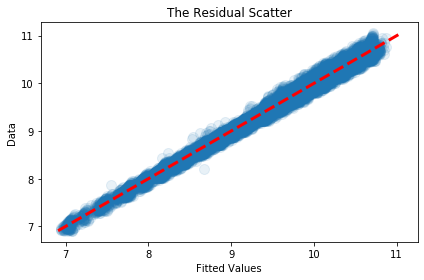

In [59]:
residual_scatter(res)

**The residual scatter shows that our model is almost around the $45^o$ line. This is expected for an $R^2 = 0.99$.**

#### (b) Model coefficients:

For a simple linear regression model, we have two coefficients; an intercept $c_0$ and a slope $c_1$ **($y = c_0 + c_1*x_1 + c_2*x_2 + c_3*x_3$)**. We use the "params" attribute to return the coefficients of the model.

In [60]:
# We can look at the estimated coefficients:
displaybd("Estimated coefficients:")
print(np.round(res.params,2))

**Estimated coefficients:**

Intercept            -0.17
term[T. 60 months]    0.03
loan_amnt             1.00
int_rate              0.11
dtype: float64


**Due to the log transformation, interpreting these coefficients isn't intuitve.**

#### (c) Heteroskedasticity:

To evaluate the hetroskedasticity, we can first use a residual plot.

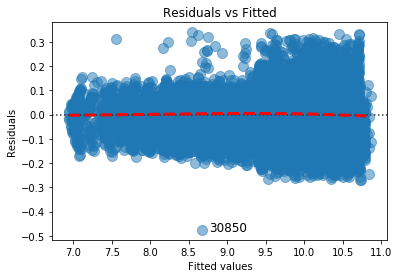

In [61]:
residual_plot(res,loan_club_fully_paid_log,'total_pymnt')

**With log transformation, the hetroskedasticity has been significantly reduced. The variance of the residuals is almost consistnet.** 

#### (d): heteroskedasticity-robust standard errors 

To incorporate the effect of hetroskedasticity, we can fit our linear regression under the assumption of heteroskedasticity-robust standard error. 

In [62]:
# PART 2.2: Regression of total_pymnt on loan_amnt, int_rate, and term with
# heteroskedasticity-robust standard errors

# Using the option cov_type='HC0' will use White’s
# heteroskedasticity-robust standard errors:
res = model.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_pymnt   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.082e+06
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        17:08:26   Log-Likelihood:                 40904.
No. Observations:               33887   AIC:                        -8.180e+04
Df Residuals:                   33883   BIC:                        -8.177e+04
Df Model:                           3                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1747      0.006    -27.364      0.000      -0.187      -0.162
term[T. 60 months]     0.0323      0.001     22.669      0.000       0.029       0.035
loan_amnt              1.0041      0.001   1738.643      0.000       1.003       1.005
int_rate               0.1079      0.001     86.920      0.000       0.106       0.110
==============================================================================
Omnibus:                      973.077   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2406.919
Skew:                          -0.091   Prob(JB):                         0.00
Kurtosis:                       4.293   Cond. No.                         166.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

**Due to the large sample size, we can't see any differences in the fitted model under the heteroscedasticity robust assumption.** 

We can futher compare the errors of the standard model and the heteroscedastic model.

In [63]:
res_standrad = model.fit()
res_hetroskedasticity = model.fit(cov_type='HC0')
displaybd("Standard Errors Vs. Heteroskedasticity errors:")
print("Standrad Errors: ",np.round(np.sqrt(res_standrad.scale),2))
print("Heteroskedasticity Robust Standard Errors: ",np.round(np.sqrt(res_hetroskedasticity.scale),2))


**Standard Errors Vs. Heteroskedasticity errors:**

Standrad Errors:  0.07
Heteroskedasticity Robust Standard Errors:  0.07


**Again,even with the heteroscedasticity in the data, there is no clear change in the residual errors due to the large sample size. Thus, we can use any of the model interchangeably.**  

#### (e) Heteroskedasticity Coefficients:

In [64]:
displaybd("95% Confidence Intervals of the estimated coefficients:")
print(res_hetroskedasticity.conf_int(alpha=0.05, cols=None))

**95% Confidence Intervals of the estimated coefficients:**

                           0         1
Intercept          -0.187244 -0.162214
term[T. 60 months]  0.029494  0.035077
loan_amnt           1.002983  1.005246
int_rate            0.105501  0.110369


**These confidence intervals are far from zero, which suggests we reject the null hypothesis for all coefficients.**

In [65]:
print(res_hetroskedasticity.t_test(np.eye(4)))


                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1747      0.006    -27.364      0.000      -0.187      -0.162
c1             0.0323      0.001     22.669      0.000       0.029       0.035
c2             1.0041      0.001   1738.643      0.000       1.003       1.005
c3             0.1079      0.001     86.920      0.000       0.106       0.110


#### (f) Leverage Points:

Leverage points can damage the goodness of fit of our model, since they fall far from other typical cluster of features. The leverage plot could help determine any leverage points.

Top 3 leverage points:  [29135 15561 27163]


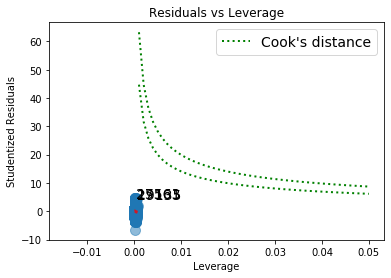

In [66]:
leverage_plot(res)

**There is no clear leverage points since all of the points are relatively far from the cook's distance line.**

#### (g) Outliers:

Even through outliers wouldn't affect our regression line as severly as leverage points would, exploring these points is important as they might indicate some problems with the data or some meaningful insights.

For more than two features, visualization of outliers might be a bit challenging. A scale-location plot could help us spot the outliers in this case.

[30850 15561 28692]


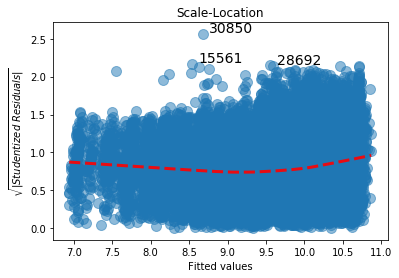

In [67]:
scale_location_plot(res)

**The outliers aren't that severe. So we can ignore them for now.**

#### (h) VIF:

Variance Inflation Factor (VIF) can help detect any collinearity. Features with VIF greater than 5, or 10 are considered multicollinear.

In [68]:
VIF(loan_club_fully_paid,'total_pymnt~loan_amnt+int_rate+term')

   VIF Factor            features
0        1.37  term[T. 60 months]
1        1.16           loan_amnt
2        1.20            int_rate


**All VIF factors are relatively small, so all features are relevant.**

#### (i) Prediction: 

Given the log transformation, we need to make sure to reverse this transformation in case of prediction.

In [69]:
# We can predict out-of-sample total_amount with its 95% confidence and prediction intervals:
# Confidence intervals are mean_ci_lower and mean_ci_upper
# Prediction intevals are obs_ci_lower and obs_ci_upper
prediction = res.get_prediction(exog=dict(loan_amnt=np.log(np.array([1e3, 1e4, 5e4])),
                                         int_rate=np.log(np.array([5, 10, 20])),
                                         term=[' 36 months', ' 36 months', ' 60 months']))
displaybd("Predicted values with their confidence and prediction intervals:")
display(np.exp(prediction.summary_frame(alpha=0.5)))

**Predicted values with their confidence and prediction intervals:**

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1027.786747,1.001732,1026.587802,1028.987093,978.808556,1079.215738
1,11181.735765,1.000305,11179.437346,11184.034656,10649.024850,11741.095216
2,62642.402074,1.001608,62574.566175,62710.311513,59657.353605,65776.812086


- **Given the high accuracy of our model, these values are expected to be much better than previous models.**  
- **We can note the relatively-narrow confidence and prediction intervals; showing the power of the model.**

## Conclusion:

In this notebook, we used linear regression to predict the total payment of a loan given the loan amount, interest rate, and term. By comparing simple model and multiple model, we can note that introducing more relevant features can improve the model fitness. In addition to $R^2$ score, diagnositc plots are important to detect any issue with the model or the data such as hetroskedasticity, leverage points, or outliers. Finally, using nonlinear transformations of relevant features can help improve the model fitness for skewed data.  